# DAMLAS4-MSP DaQuiri Baseline Model

In [1]:
import os
import sys
import dateutil.parser
import dateutil.relativedelta as dateutil_rd

spark_path = "C:/opt/spark"

os.environ['SPARK_HOME'] = spark_path
os.environ['HADOOP_HOME'] = spark_path

sys.path.append(spark_path + "/bin")
sys.path.append(spark_path + "/python")
sys.path.append(spark_path + "/python/pyspark/")
sys.path.append(spark_path + "/python/lib")
sys.path.append(spark_path + "/python/lib/pyspark.zip")
sys.path.append(spark_path + "/python/lib/py4j-0.9-src.zip")

from pyspark import SparkContext
from pyspark import SparkConf
from pyspark import SQLContext

sc = SparkContext("local", "test")
sqlContext = SQLContext(sc)

In [2]:
print(sc)
print(sqlContext)

In [3]:
%%javascript
/**********************************************************************************************
Known Mathjax Issue with Chrome - a rounding issue adds a border to the right of mathjax markup
https://github.com/mathjax/MathJax/issues/1300
A quick hack to fix this based on stackoverflow discussions: 
http://stackoverflow.com/questions/34277967/chrome-rendering-mathjax-equations-with-a-trailing-vertical-line
**********************************************************************************************/

$('.math>span').css("border-left-color","transparent")

<IPython.core.display.Javascript object>

In [4]:
%reload_ext autoreload
%autoreload 2
%pdb

Automatic pdb calling has been turned ON


In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric import smoothers_lowess
from pandas import Series, DataFrame
from patsy import dmatrices, ModelDesc
from sklearn import datasets, svm

In [6]:
df = pd.read_csv("daquiri.csv",parse_dates=[0]) 
df2 = pd.read_csv("daquiri_test.csv",parse_dates=[0])

df['event_min'] = df['event_min'].map({1:14, 2:29, 3:44, 4:59})
df2['event_min'] = df2['event_min'].map({1:14, 2:29, 3:44, 4:59})

df['event_ts'] = df['event_dt'].astype(str)+' '+df['event_hr'].astype(str)+':'+df['event_min'].astype(str)+':59.999999'
df2['event_ts'] = df2['event_dt'].astype(str)+' '+df2['event_hr'].astype(str)+':'+df2['event_min'].astype(str)+':59.999999'
df['event_ts'] = pd.to_datetime(df['event_ts'])
df2['event_ts'] = pd.to_datetime(df2['event_ts'])

cols = df.columns.tolist()
cols = ['event_ts']  + [col for col in df if col != 'event_ts']
df = df[cols]

In [7]:
cols = df2.columns.tolist()
cols = ['event_ts']  + [col for col in df2 if col != 'event_ts']
df2 = df2[cols]

In [8]:
df.shape

(11424, 36)

In [9]:
df.head()

,event_ts,event_dt,event_hr,event_min,unq_visitors,unq_ip,cookie_disabl_true,sign_in_rem,sign_in_no,sign_in_unk,...,lvl4_cnt,pgld_cnt,atp_cnt,rec_cnt,click_cnt,tcin_cnt,compld_cnt,event_cnt,demand_sales,order_cnt
0,2016-07-10 17:14:59.999999,2016-07-10,17,14,79323,431075,0,45298,563581,33067,...,25116,399484,74185,250690,18357,41400,1927,786043,172020.32990,2496
1,2016-07-11 07:14:59.999999,2016-07-11,7,14,18465,99632,0,12043,143508,8807,...,7486,100790,20635,65242,5049,11226,548,203490,32150.23004,507
2,2016-07-10 06:59:59.999999,2016-07-10,6,59,20935,105836,0,15895,159932,9426,...,8977,115883,22273,72429,5459,11757,437,228238,67797.87003,611
3,2016-07-10 07:14:59.999999,2016-07-10,7,14,20019,101279,0,12642,144108,8190,...,7172,102434,19918,65288,4769,10284,391,203084,31261.28998,412
4,2016-07-10 19:29:59.999999,2016-07-10,19,29,83036,403254,0,51072,602666,38016,...,27948,430151,83378,271379,19896,48860,2069,855733,184884.81020,2718


In [10]:
#df2.head()

In [11]:
df = df.drop('cookie_disabl_true', axis=1)
df = df.drop('wkly_ad_cnt',axis=1)
df = df.dropna()
df['dayofwk'] = df['event_dt'].dt.dayofweek

df2 = df2.drop('cookie_disabl_true', axis=1)
df2 = df2.drop('wkly_ad_cnt',axis=1)
df2 = df2.dropna()
df2['dayofwk'] = df2['event_dt'].dt.dayofweek

In [12]:
cols = df.columns.tolist()
cols = ['event_cnt']  + [col for col in df if col != 'event_cnt']
df = df[cols]
l1 = len(cols)
df.head()

,event_cnt,event_ts,event_dt,event_hr,event_min,unq_visitors,unq_ip,sign_in_rem,sign_in_no,sign_in_unk,...,lvl4_cnt,pgld_cnt,atp_cnt,rec_cnt,click_cnt,tcin_cnt,compld_cnt,demand_sales,order_cnt,dayofwk
0,786043,2016-07-10 17:14:59.999999,2016-07-10,17,14,79323,431075,45298,563581,33067,...,25116,399484,74185,250690,18357,41400,1927,172020.32990,2496,6
1,203490,2016-07-11 07:14:59.999999,2016-07-11,7,14,18465,99632,12043,143508,8807,...,7486,100790,20635,65242,5049,11226,548,32150.23004,507,0
2,228238,2016-07-10 06:59:59.999999,2016-07-10,6,59,20935,105836,15895,159932,9426,...,8977,115883,22273,72429,5459,11757,437,67797.87003,611,6
3,203084,2016-07-10 07:14:59.999999,2016-07-10,7,14,20019,101279,12642,144108,8190,...,7172,102434,19918,65288,4769,10284,391,31261.28998,412,6
4,855733,2016-07-10 19:29:59.999999,2016-07-10,19,29,83036,403254,51072,602666,38016,...,27948,430151,83378,271379,19896,48860,2069,184884.81020,2718,6


In [13]:
cols = df2.columns.tolist()
cols = ['event_cnt']  + [col for col in df2 if col != 'event_cnt']
df2 = df2[cols]
#df2.head()

In [33]:
df.dtypes

event_cnt                 int64
event_ts         datetime64[ns]
event_dt         datetime64[ns]
event_hr                  int64
event_min                 int64
unq_visitors              int64
unq_ip                    int64
sign_in_rem               int64
sign_in_no                int64
sign_in_unk               int64
windows_os                int64
iphone_os                 int64
mac_os                    int64
ipad_os                   int64
android_os                int64
mweb_cnt                  int64
prod_dtl_cnt              int64
pgvw_cnt                  int64
srch_rslt_cnt             int64
homepg_cnt                int64
shp_crt_cnt               int64
crt_ovrly_cnt             int64
lvl1_cnt                  int64
lvl2_cnt                  int64
lvl3_cnt                  int64
lvl4_cnt                  int64
pgld_cnt                  int64
atp_cnt                   int64
rec_cnt                   int64
click_cnt                 int64
tcin_cnt                  int64
compld_c

In [15]:
df['dayofwk'] = df['dayofwk'].astype(object)
df2['dayofwk'] = df2['dayofwk'].astype(object)

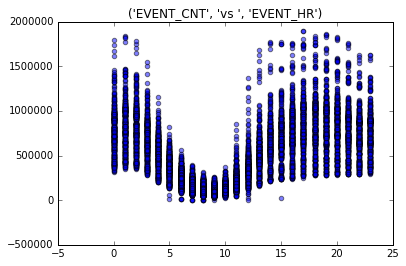

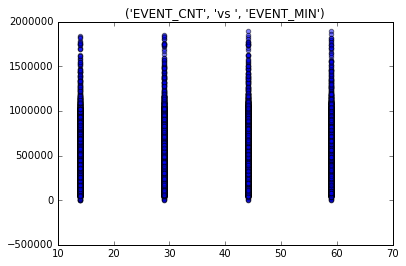

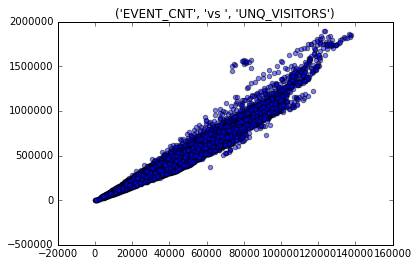

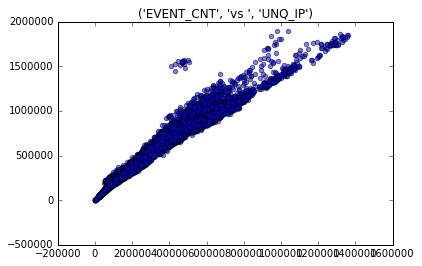

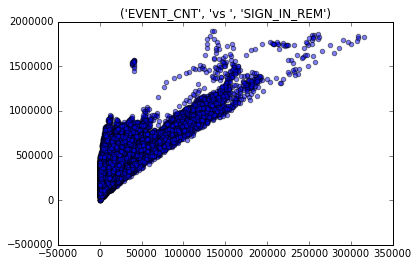

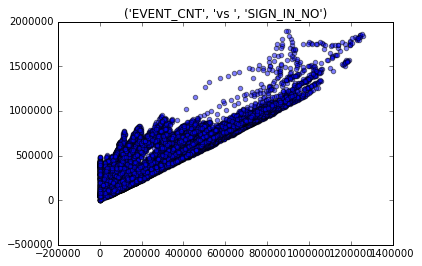

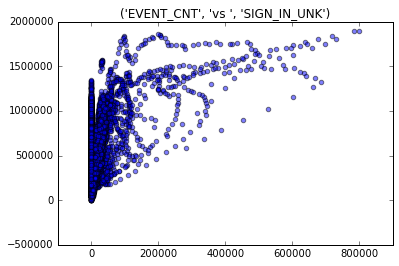

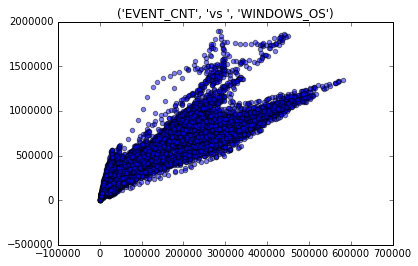

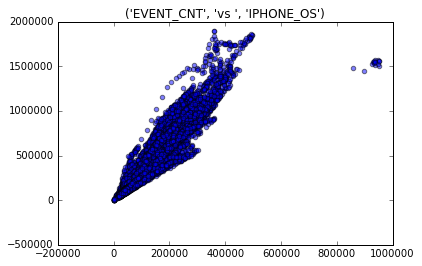

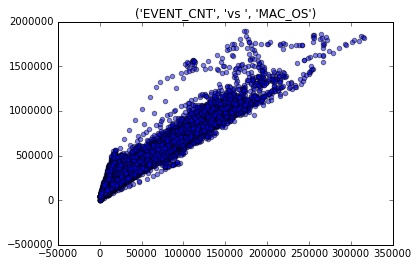

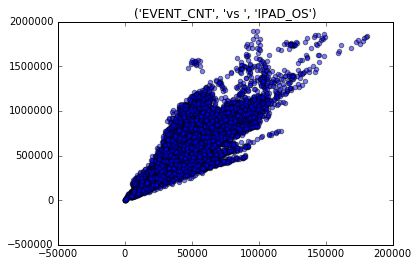

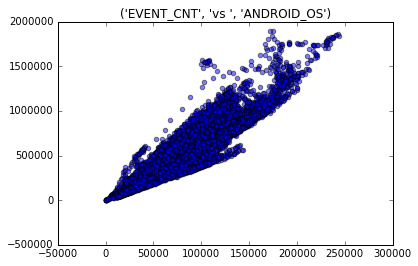

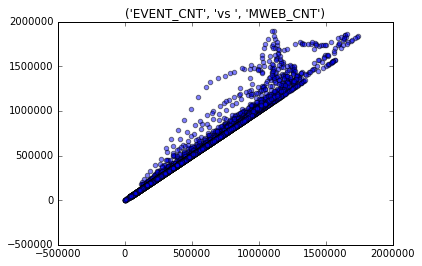

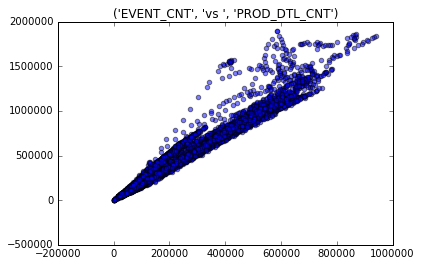

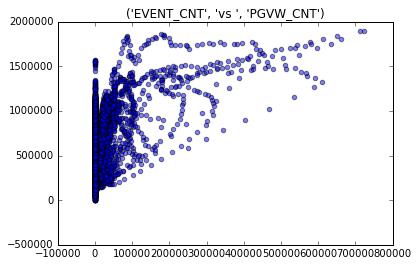

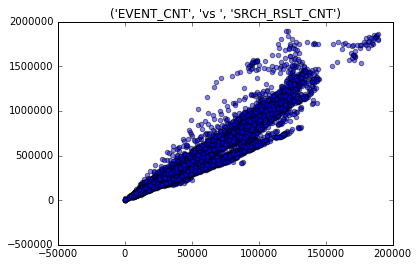

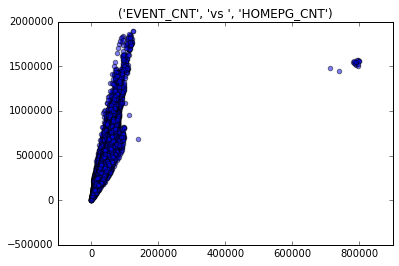

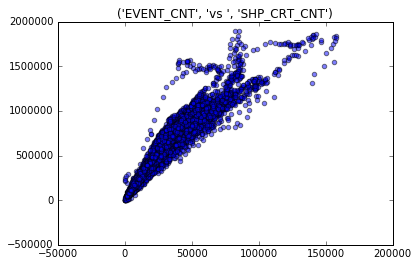

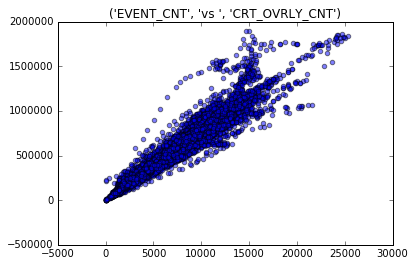

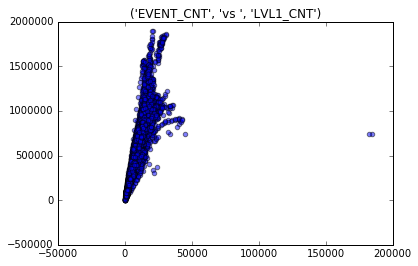

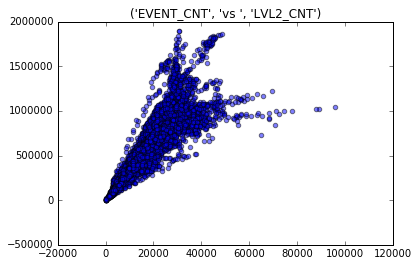

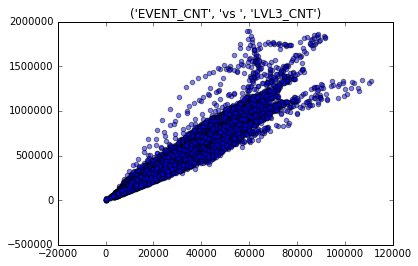

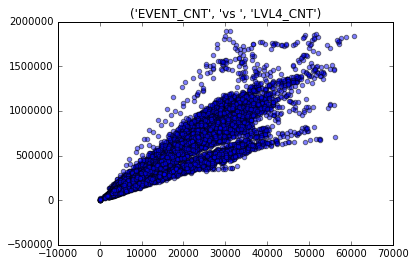

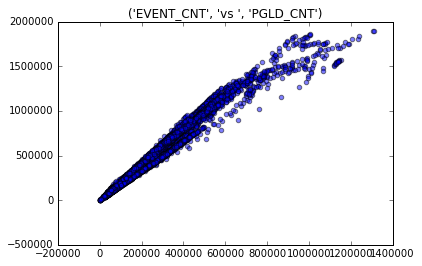

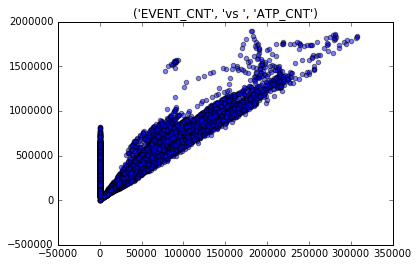

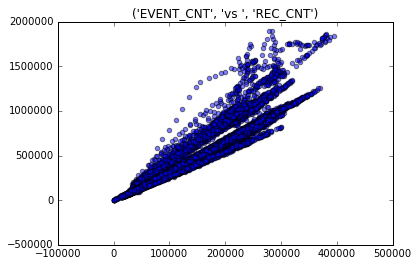

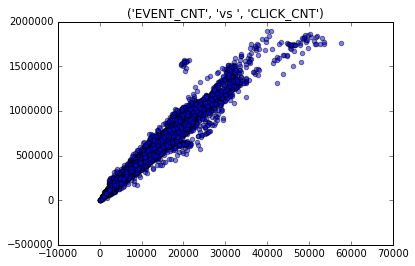

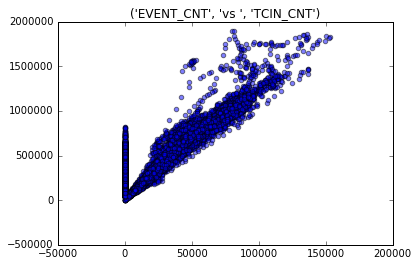

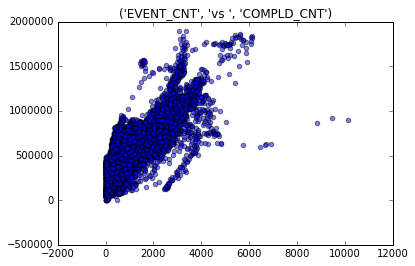

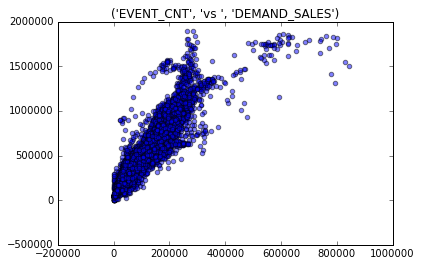

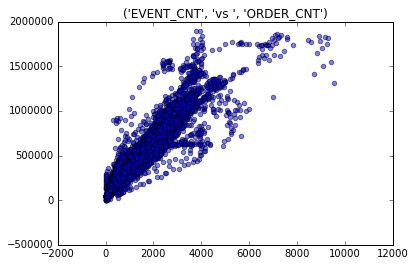

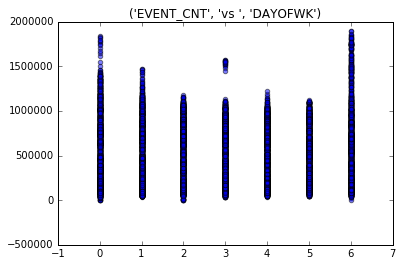

In [16]:
import matplotlib.pyplot as plt

y = df.ix[:,0]

for z in range(3,l1):
    x = df.ix[:,z]
    plt.scatter(x, y, alpha=0.5)
    ttl = df.columns[0].upper(), 'vs ', df.columns[z].upper()
    plt.title(ttl)
    plt.show()

In [17]:
feature_cols = df.columns[4:]

# define X (features) and y (response)
X = df[feature_cols]
y = df.event_cnt

In [18]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [19]:
from sklearn.tree import DecisionTreeRegressor
treereg = DecisionTreeRegressor(random_state=1)
treereg.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=1,
           splitter='best')

In [20]:
from sklearn import metrics
import numpy as np

pred_fit = treereg.predict(X_train)
np.sqrt(metrics.mean_squared_error(y_train, pred_fit))

0.0

In [21]:
pred_test = treereg.predict(X_test)

# print predictions and actual values
print pred_test[0:10]
print y_test[0:10]

[ 706549.  737739.  440239.   93547.  937764.  246920.  537435.  392963.
  654931.  425403.]
9464     706533
8750     737729
6014     429574
9059      93775
5642     938608
7137     247072
3160     524165
10519    393040
8747     655193
10880    424760
Name: event_cnt, dtype: int64


In [22]:
# print RMSE
np.sqrt(metrics.mean_squared_error(y_test, pred_test))

11969.402901859006

In [23]:
# use cross-validation to find best max_depth
from sklearn.cross_validation import cross_val_score

In [24]:
# try max_depth=10
treereg = DecisionTreeRegressor(max_depth=10, random_state=1)
scores = cross_val_score(treereg, X, y, cv=3, scoring='mean_squared_error')
np.mean(np.sqrt(-scores))

19758.894178841827

In [25]:
# try max_depth=11
treereg = DecisionTreeRegressor(max_depth=11, random_state=1)
scores = cross_val_score(treereg, X, y, cv=3, scoring='mean_squared_error')
np.mean(np.sqrt(-scores))

19617.586731483396

In [26]:
# try max_depth=12
treereg = DecisionTreeRegressor(max_depth=12, random_state=1)
scores = cross_val_score(treereg, X, y, cv=3, scoring='mean_squared_error')
np.mean(np.sqrt(-scores))

20172.824662540937

In [27]:
# max_depth=11 was best, so fit a tree using that parameter with ALL DATA
treereg = DecisionTreeRegressor(max_depth=11, random_state=1)
treereg.fit(X, y)
pd.DataFrame({'feature':feature_cols, 'importance':treereg.feature_importances_ * 10})
imp = pd.DataFrame({'feature':feature_cols, 'importance':treereg.feature_importances_ * 10})
imp_srtd = imp.sort_values(by=['importance'],ascending=False)
print "Features In Order of Importance:"
print imp_srtd

tot_imp = imp_srtd['importance'].sum()
imp_srtd['pct'] = imp_srtd['importance'] / tot_imp * 100
imp_srtd['c_pct'] = imp_srtd['pct'].cumsum()

df_f = imp_srtd.loc[imp_srtd['c_pct'] <= 99.85]
l2 = len(df_f)

for i in range(0,l2):
    if i == 0:
        f = df_f.iloc[i,0]
    else:
        f = f + '+' + df_f.iloc[i,0]
        
f2 = list(df)[0] + '~' + f

print ''
print 'Base Model Formula:'
print f2


Features In Order of Importance:
          feature  importance
11       mweb_cnt    8.389639
22       pgld_cnt    1.561923
25      click_cnt    0.015646
13       pgvw_cnt    0.010682
8          mac_os    0.006533
5     sign_in_unk    0.003613
4      sign_in_no    0.002307
26       tcin_cnt    0.001868
29      order_cnt    0.001849
24        rec_cnt    0.000928
18       lvl1_cnt    0.000720
12   prod_dtl_cnt    0.000594
1    unq_visitors    0.000560
7       iphone_os    0.000501
2          unq_ip    0.000464
14  srch_rslt_cnt    0.000371
16    shp_crt_cnt    0.000312
20       lvl3_cnt    0.000252
6      windows_os    0.000211
19       lvl2_cnt    0.000138
28   demand_sales    0.000131
0       event_min    0.000107
17  crt_ovrly_cnt    0.000102
3     sign_in_rem    0.000095
23        atp_cnt    0.000093
15     homepg_cnt    0.000082
21       lvl4_cnt    0.000076
9         ipad_os    0.000073
30        dayofwk    0.000064
27     compld_cnt    0.000036
10     android_os    0.000031

Base M

In [28]:
formula = f2
# create a results dictionary to hold our regression results for easy analysis later        
results = {}

In [29]:
desc = ModelDesc.from_formula(formula)
desc.describe()

'event_cnt ~ mweb_cnt + pgld_cnt + click_cnt + pgvw_cnt + mac_os'

In [30]:
print formula
y,x = dmatrices(desc.describe(),data=df,return_type='dataframe')

event_cnt~mweb_cnt+pgld_cnt+click_cnt+pgvw_cnt+mac_os


In [31]:
model = sm.OLS(y,x)

# fit our model to the training data
results = model.fit()
res_v = model.fit().params.values
print 'Model Parameters:'
print results.params
print ''
print 'Model T-Values:'
print results.tvalues

results.summary()

Model Parameters:
Intercept   -196.584894
mweb_cnt       0.993480
pgld_cnt       0.016993
click_cnt     -0.133850
pgvw_cnt       1.095488
mac_os         0.017495
dtype: float64

Model T-Values:
Intercept     -2.636088
mweb_cnt     910.711298
pgld_cnt      11.100491
click_cnt     -6.434799
pgvw_cnt     608.022144
mac_os         6.587558
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              event_cnt   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.235e+07
Date:                Thu, 22 Sep 2016   Prob (F-statistic):               0.00
Time:                        19:56:28   Log-Likelihood:            -1.0923e+05
No. Observations:               11424   AIC:                         2.185e+05
Df Residuals:                   11418   BIC:                         2.185e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   -196.5849     74.574     -2.636      0.008      -342.764   -50.406
mweb_cnt       0.9935      0.001    910.711      0.000         0.991     0.996
pgld_cnt       0.0170      0.002     11.100      0.000         0.014     0.020
click_cnt     -0.1338      0.021     -6.435      0.000        -0.175    -0.093
pgvw_cnt       1.0955      0.002    608.022      0.000         1.092     1.099
mac_os         0.0175      0.003      6.588      0.000         0.012     0.023
==============================================================================
Omnibus:                    19631.724   Durbin-Watson:                   1.820
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         14243855.268
Skew:                          12.194   Prob(JB):                         0.00
Kurtosis:                     174.258   Cond. No.                     1.69e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.69e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [32]:
import statsmodels.formula.api as smf
est = smf.ols(formula=desc.describe(), data=df2).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              event_cnt   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.595e+05
Date:                Thu, 22 Sep 2016   Prob (F-statistic):               0.00
Time:                        19:56:28   Log-Likelihood:                -5057.2
No. Observations:                 480   AIC:                         1.013e+04
Df Residuals:                     474   BIC:                         1.015e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   1.168e+04   1393.725      8.380      0.000      8940.621  1.44e+04
mweb_cnt      -0.0239      0.002    -10.369      0.000        -0.028    -0.019
pgld_cnt       1.8514      0.024     77.399      0.000         1.804     1.898
click_cnt      1.1394      0.360      3.161      0.002         0.431     1.848
pgvw_cnt      -0.9100      0.016    -57.916      0.000        -0.941    -0.879
mac_os         0.4922      0.044     11.275      0.000         0.406     0.578
==============================================================================
Omnibus:                       13.100   Durbin-Watson:                   1.605
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               16.940
Skew:                          -0.269   Prob(JB):                     0.000210
Kurtosis:                       3.747   Cond. No.                     2.83e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.83e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""